In [37]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd
from bisect import *

In [39]:
layerStart = [0,96,320,672,1184,1296,1408,1520,1632,1744,1856]
layerName = ["BL1","BL2","BL3","BL4","E+1", "E+2", "E+3","E-1", "E-2", "E-3"]
def layer(x) :
    return bisect_right(layerStart, x)

print layer(0),layer(1),layer(95),layer(96),layer(97),layer(1743),layer(1744),layer(1855)

i2p = math.pi/32769.0

1 1 1 2 2 9 10 10


In [40]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, first, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
    y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
    x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
    y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
    x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
    y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius # - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [114]:
def deltaphi(a,b,ch) :
    cb = ch*b
    ca = ch*a
    return np.arcsin(cb) - np.arcsin(ca)


def deltaphiA(a,b,ch) :
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)


def eta(r,z) :
    t = z/r
    return np.arcsinh(t);


In [115]:
def alignRZ(h, rp, ptmin, first) :
    '''
    float radius_diff = std::abs(r1 - ro);
    float distance_13_squared = radius_diff*radius_diff + (z1 - zo)*(z1 - zo);
    
    float pMin = ptmin*std::sqrt(distance_13_squared); //this needs to be divided by radius_diff later
    
    float tan_12_13_half_mul_distance_13_squared = fabs(z1 * (getInnerR() - ro) + getInnerZ() * (ro - r1) + zo * (r1 - getInnerR())) ;
    return tan_12_13_half_mul_distance_13_squared * pMin <= thetaCut * distance_13_squared * radius_diff;
    '''
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
    fact = 1. if (rp=='r') else 10.
    radius_diff = fact*abs(ri - ro)
    distance_13_squared = radius_diff*radius_diff + (zi - zo)*(zi - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = fact*abs(zi * (rm - ro) + zm * (ro - ri) + zo * (ri - rm)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [116]:
def alignRPZ(h, rp, first) :
    ri = h[rp+'1'] if first else h[rp+'2']
    zi = h['z1'] if first else h['z2']
    rm = h[rp+'2'] if first else h[rp+'3']
    zm = h['z2'] if first else h['z3']
    ro = h[rp+'3'] if first else h[rp+'4']
    zo = h['z3'] if first else h['z4']
     
    return (rm-ri)*(zo-zm) - (ro-rm)*(zm-zi)

In [117]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [118]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [119]:
file = '/Users/innocent/data/ttbarPU50Hits.csv'
# file = '/Users/innocent/data/ttbarPU0Hits.csv'
rawHits = pd.read_csv(file, delimiter=" ")
print '#rawhits', len(rawHits)

#rawhits 6842643


In [120]:
rawHits['phi'] =  np.arctan2(rawHits['yg'],rawHits['xg']) # rawHits['iphi']*i2p
rawHits['eta'] =  eta(rawHits['rg'],rawHits['zg'])
rawHits['seq'] = rawHits['det'].apply(layer)
rawHits['trackID'] = rawHits['tkId']+10000000*rawHits['ev']
rawHits.sort_values(by=['ev','tkId','det'],inplace=True)
hits =  rawHits[rawHits['pt']>400]
print '#hits', len(hits)
print hits.head()
print hits.tail()

#hits 2865257
       ev   ind   det  charge        xg         yg         zg         rg  \
2068    1  3380   261   39382 -0.719951  -7.235875  12.478751   7.271603   
5523    1  4947   582   61290 -0.775613 -11.347950  19.134975  11.374425   
109     1  1549    66   75059 -0.153022  -3.402119  -9.927705   3.405559   
2865    1  3345   256  114378 -0.533277  -7.253811 -22.095730   7.273387   
10198   1  9090  1567   25476 -1.101961 -10.707680 -33.038609  10.764234   

        iphi  tkId   pt  n1  tkId2  pt2  n2       phi       eta  seq   trackID  
2068  -17419     0  769   3      0    0   0 -1.669967  1.308952    2  10000000  
5523  -17096     0  769   3      0    0   0 -1.639038  1.291801    3  10000000  
109   -16853     2  740   7      0    0   0 -1.615744 -1.791266    1  10000002  
2865  -17150     2  740   8      0    0   0 -1.644181 -1.830360    2  10000002  
10198 -17455     2  740   3      0    0   0 -1.673348 -1.840135    8  10000002  
          ev    ind   det  charge         x

In [121]:
#print hits[hits['tkId']==3].head(50)

648743 455518 369878 305588 355791 363545 366194


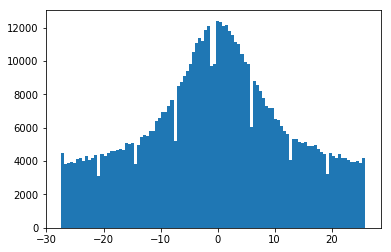

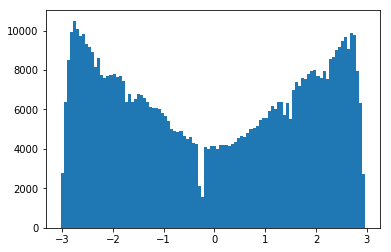

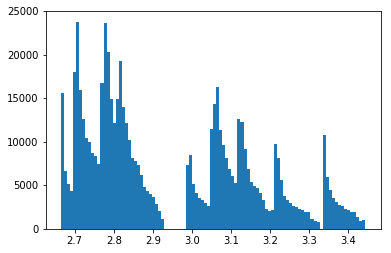

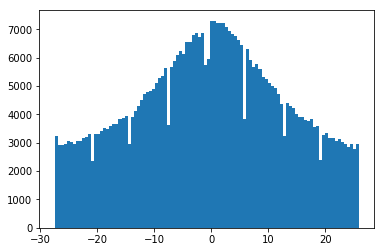

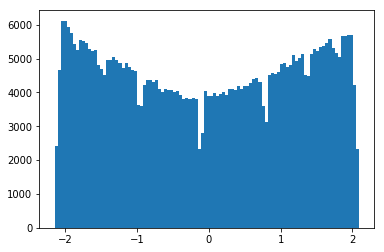

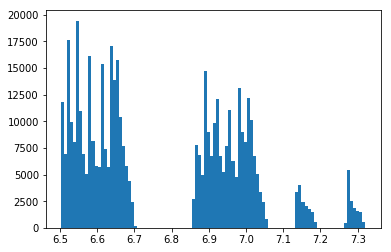

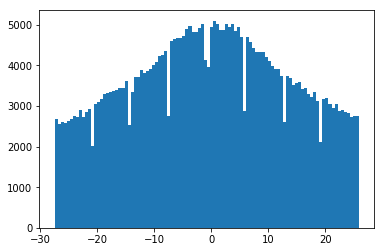

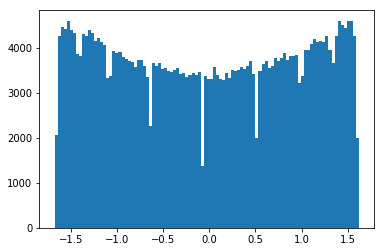

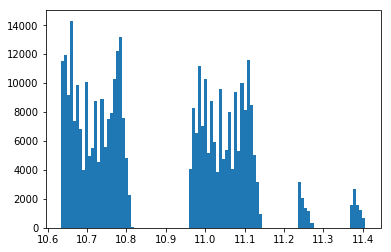

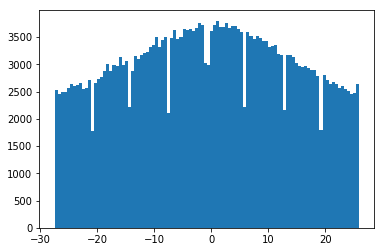

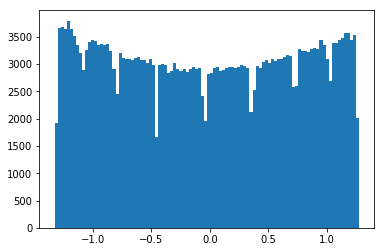

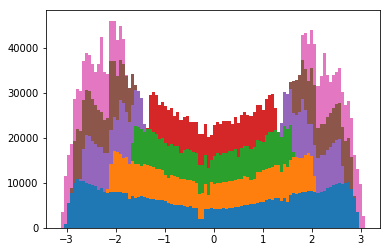

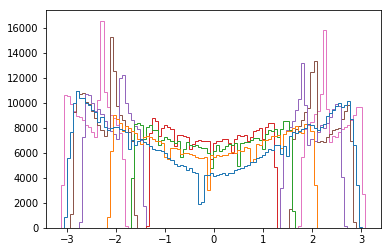

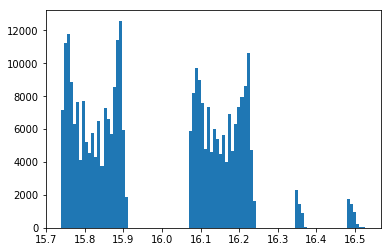

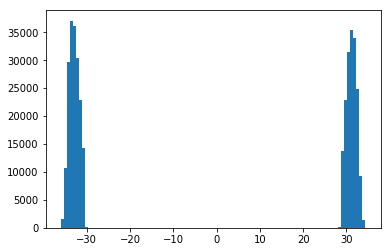

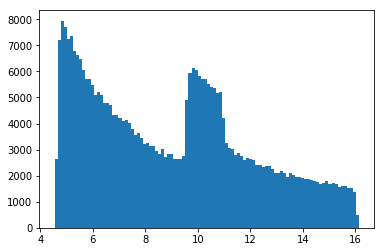

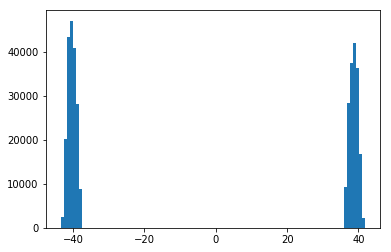

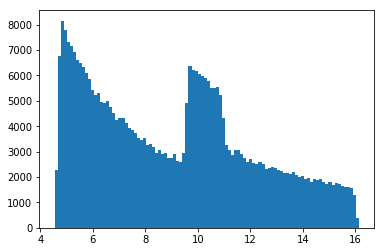

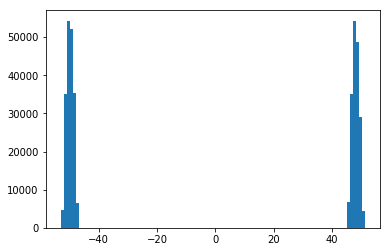

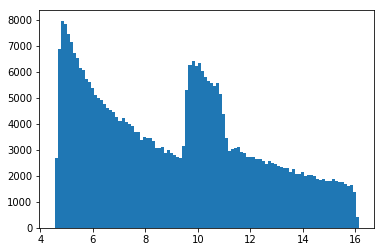

In [122]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5 or seq==8')
hf2 = hits.query('seq==6 or seq==9')
hf3 = hits.query('seq==7 or seq==10')

print len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3)
plt.hist(hb1['zg'],log=False, bins=100)
plt.show()
plt.hist(hb1['eta'],log=False, bins=100)
plt.show()
plt.hist(hb1['rg'],log=False, bins=100)
plt.show()
plt.hist(hb2['zg'],log=False, bins=100)
plt.show()
plt.hist(hb2['eta'],log=False, bins=100)
plt.show()
plt.hist(hb2['rg'],log=False, bins=100)
plt.show()
plt.hist(hb3['zg'],log=False, bins=100)
plt.show()
plt.hist(hb3['eta'],log=False, bins=100)
plt.show()
plt.hist(hb3['rg'],log=False, bins=100)
plt.show()
plt.hist(hb4['zg'],log=False, bins=100)
plt.show()
plt.hist(hb4['eta'],log=False, bins=100)
plt.show()
data = [hb1['eta'],hb2['eta'],hb3['eta'],hb4['eta'],hf1['eta'],hf2['eta'],hf3['eta']]
plt.hist(data,log=False, bins=100, histtype='barstacked')
plt.show()
plt.hist(data,log=False, bins=100, histtype='step')
plt.show()


plt.hist(hb4['rg'],log=False, bins=100)
plt.show()
plt.hist(hf1['zg'],log=False, bins=100)
plt.show()
plt.hist(hf1['rg'],log=False, bins=100)
plt.show()
plt.hist(hf2['zg'],log=False, bins=100)
plt.show()
plt.hist(hf2['rg'],log=False, bins=100)
plt.show()
plt.hist(hf3['zg'],log=False, bins=100)
plt.show()
plt.hist(hf3['rg'],log=False, bins=100)
plt.show()


In [123]:
print 'min/max'
print hb1.agg(['min','max'])
print hb2.agg(['min','max'])
print hb3.agg(['min','max'])
print hb4.agg(['min','max'])
print hf1.agg(['min','max'])
print hf2.agg(['min','max'])
print hf3.agg(['min','max'])

min/max
      ev   ind  det   charge        xg        yg         zg        rg   iphi  \
min    1     0    0      696 -3.133961 -3.443828 -27.465214  2.664958 -32766   
max  500  4931   95  6379805  3.184488  3.305549  25.885403  3.443848  32766   

       tkId      pt   n1   tkId2     pt2  n2       phi       eta  seq  \
min       0     401    1       0       0   0 -3.141559 -3.027653    1   
max  145940  236569  173  144781  155324  70  3.141505  2.968422    1   

        trackID  
min    10000002  
max  5000114033  
      ev   ind  det   charge        xg        yg         zg        rg   iphi  \
min    1  1349   96      627 -6.956163 -7.319355 -27.465387  6.502839 -32767   
max  500  8491  319  6790313  7.005610  7.180817  25.886454  7.320724  32766   

       tkId      pt   n1   tkId2    pt2   n2       phi       eta  seq  \
min       0     401    1       0      0    0 -3.141582 -2.147105    2   
max  145940  255145  241  145934  81469  164  3.141493  2.089339    2   

        trackID 

In [124]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['zg'],
                    'r'+n : hh['rg'],
                    'phi'+n : hh['phi'],
                    'pt'+n : hh['pt'],
                    'trackID' : hh['trackID']
                       })


In [125]:
def fishBone(q,t,p,c) :
 return pd.DataFrame({ 'th' : t,
                       'pz' : p,
                       'curv' : c,
                       'trackID' : q['trackID']
                       })


In [126]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t23 = pd.merge(build(hb2,'1'),build(hb3,'2'),on='trackID')
t34 = pd.merge(build(hb3,'1'),build(hb4,'2'),on='trackID')
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
print len(t12)
print len(t23)
print len(t34)
print len(t123)
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print len(t1234)
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print len(t1231)
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print len(t1212)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print len(t1123)

qall = pd.concat([t1234,t1231,t1212,t1123])
print len(qall)
print t1234.head()
print t1231.head()
print t1212.head()
print t1123.head()

548570
493149
434057
792527
2274850
540108
483260
931967
4230185
       phi1   pt1        r1   trackID       z1      phi2   pt2        r2  \
0 -0.534839  1698  3.209876  10000005 -2.03853 -0.522814  1698  6.636066   
1 -0.534839  1698  3.209876  10000005 -2.03853 -0.522814  1698  6.636066   
2 -0.534839  1698  3.209876  10000005 -2.03853 -0.522814  1698  6.636066   
3 -0.534839  1698  3.209876  10000005 -2.03853 -0.522814  1698  6.636066   
4 -0.534839  1698  3.209876  10000005 -2.03853 -0.508068  1698  6.638935   

         z2      phi3   pt3         r3        z3      phi4   pt4         r4  \
0 -5.024552 -0.506715  1698  11.091832 -8.901971 -0.469588  1698  16.203526   
1 -5.024552 -0.506715  1698  11.091832 -8.901971 -0.464408  1698  16.201468   
2 -5.024552 -0.506715  1698  11.091832 -8.901971 -0.488653  1698  16.214857   
3 -5.024552 -0.506715  1698  11.091832 -8.901971 -0.471780  1698  16.204531   
4 -5.171747 -0.506715  1698  11.091832 -8.901971 -0.469588  1698  16.203526   

   

In [127]:
def plot(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  print 'dpt'
  plt.hist(quad['pt1']-quad['pt2'],log=True, bins=100)
  plt.show()
  plt.hist(quad['pt2']-quad['pt3'],log=True, bins=100)
  plt.show()
  plt.hist(quad['pt3']-quad['pt4'],log=True, bins=100)
  plt.show()


  print 'delta123', len(quadc)
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()

    
  thcut = alignRZ(quadc,'r',0.6,True)
  pzcut = alignRZ(quadc,'phi',1.0,True)
  thcut2 = alignRPZ(quadc,'r',True)
  pzcut2 = alignRPZ(quadc,'phi',True)

  curv = curvature(quadc,0.6,0.02,0.2,True)
  rad = curvature(quadc,0.6,0.02,0.2,True,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut,pzcut,curvcut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()

  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.4],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.4],log=True, bins=100)
  plt.show()




  fb123 = fishBone(quadc,thcut,pzcut,curv)
  fb = pd.merge(fb123,fb123,on='trackID')
  print 'fishbone', len(fb)  
  fb = fb[fb['curv_x']!=fb['curv_y']]
  print fb.head()
  dt = fb['th_x']-fb['th_y']
  dz = fb['pz_x']-fb['pz_y']
  dc = fb['curv_x']-fb['curv_y']
  print 'fishbone', len(fb), len(dt), len(dc)
  plt.hist(dt,log=True, bins=100)
  plt.show()
  plt.hist(dz,log=True, bins=100)
  plt.show()
  plt.hist(dc,log=True, bins=100)
  plt.show()

  plt.hist(dt[abs(dt)<0.002],log=False, bins=100)
  plt.show()
  plt.hist(dz[abs(dz)<0.01],log=False, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.01],log=False, bins=100)
  plt.show()
  
  print 'delta234'

  thcut = alignRZ(quadc,'r',0.6,False)
  pzcut = alignRZ(quadc,'phi',1.0,False)
  thcut2 = alignRPZ(quadc,'r',False)
  pzcut2 = alignRPZ(quadc,'phi',False)
  curv = curvature(quadc,0.6,0.02,0.2,False)
  rad = curvature(quadc,0.6,0.02,0.2,False,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut,pzcut,curvcut',len(thcut)
  plt.hist(thcut[thcut<0.004],log=True, bins=100)
  plt.show()
  plt.hist(pzcut[pzcut<0.4],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()

    
  print 'thcut2,pzcut2',len(thcut2)
  plt.hist(thcut2[abs(thcut2)<0.4],log=True, bins=100)
  plt.show()
  plt.hist(pzcut2[abs(pzcut2)<0.4],log=True, bins=100)
  plt.show()

    
  fb234 = fishBone(quadc,thcut,pzcut,curv)
  fb = pd.merge(fb234,fb234,on='trackID')
  print 'fishbone', len(fb)  
  fb = fb[fb['curv_x']!=fb['curv_y']]
  print fb.head()
  dt = fb['th_x']-fb['th_y']
  dz = fb['pz_x']-fb['pz_y']
  dc = fb['curv_x']-fb['curv_y']
  print 'fishbone', len(fb), len(dt), len(dc)
  plt.hist(dt,log=True, bins=100)
  plt.show()
  plt.hist(dz,log=True, bins=100)
  plt.show()
  plt.hist(dc,log=True, bins=100)
  plt.show()

  plt.hist(dt[abs(dt)<0.002],log=False, bins=100)
  plt.show()
  plt.hist(dz[abs(dz)<0.1],log=False, bins=100)
  plt.show()
  plt.hist(dc[abs(dc)<0.01],log=False, bins=100)
  plt.show()
 
    



In [163]:
def plotDoublets(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  maxc = 0.5*mpt/87000.

  print 'dphi'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[abs(d1)<.1], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[abs(d2)<.1], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<.1], bins=100,log=True)
  plt.show()

  pcut = np.logical_and(abs(d1)<0.05,np.logical_and(abs(d2)<0.05,abs(d3)<0.05))


  print 'dphiNor'
    
  pc = deltaphi(quadc['r1'],quadc['r2'],maxc)
  d1 = (quadc['phi2']-quadc['phi1'])/pc
  plt.hist(d1[abs(d1)<4.], bins=100,log=True)
  plt.show()
  pc = deltaphi(quadc['r2'],quadc['r3'],maxc)
  d2 = (quadc['phi3']-quadc['phi2'])/pc
  plt.hist(d2[abs(d2)<4.], bins=100,log=True)
  plt.show()
  pc = deltaphi(quadc['r3'],quadc['r4'],maxc)
  d3 = (quadc['phi4']-quadc['phi3'])/pc
  plt.hist(d3[abs(d3)<4.], bins=100,log=True)
  plt.show()


  print 'dz'
  d1 = quadc['z2']-quadc['z1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<35)], bins=100,log=True)
  plt.show()
  d2 = quadc['z3']-quadc['z2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<35)], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<35)], bins=100,log=True)
  plt.show()

  print 'z0'
  d1 = (quadc['r1']*quadc['z2']-quadc['z1']*quadc['r2'])/(quadc['r1']-quadc['r2'])
  plt.hist(d1[np.logical_and(pcut,abs(d1)<50)], bins=100,log=True)
  plt.show()
  d2 = (quadc['r2']*quadc['z3']-quadc['z2']*quadc['r3'])/(quadc['r2']-quadc['r3'])
  plt.hist(d2[np.logical_and(pcut,abs(d2)<50)], bins=100,log=True)
  plt.show()
  d3 = (quadc['r3']*quadc['z4']-quadc['z3']*quadc['r4'])/(quadc['r3']-quadc['r4'])
  plt.hist(d3[np.logical_and(pcut,abs(d3)<50)], bins=100,log=True)
  plt.show()
  

  pcut = np.logical_and(abs(d1)<10.,np.logical_and(abs(d2)<10.,abs(d3)<10.))


  print 'dr'
  d1 = quadc['r2']-quadc['r1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<20)], bins=100,log=True)
  plt.show()
  d2 = quadc['r3']-quadc['r2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<20)], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<20)], bins=100,log=True)
  plt.show()

  print 'dphi zcut'
  d1 = quadc['phi2']-quadc['phi1']
  plt.hist(d1[np.logical_and(pcut,abs(d1)<.1)], bins=100,log=True)
  plt.show()
  d2 = quadc['phi3']-quadc['phi2']
  plt.hist(d2[np.logical_and(pcut,abs(d2)<.1)], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[np.logical_and(pcut,abs(d3)<.1)], bins=100,log=True)
  plt.show()


    
    

In [164]:
#for quad in [t1234,t1231,t1212,t1123] :
#  plot(quad,600)

dphi


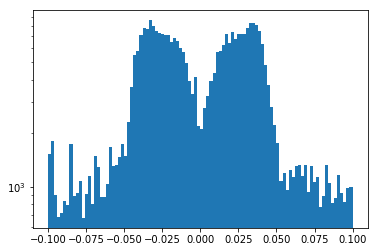

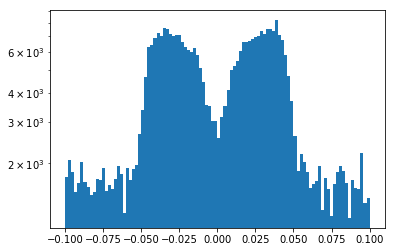

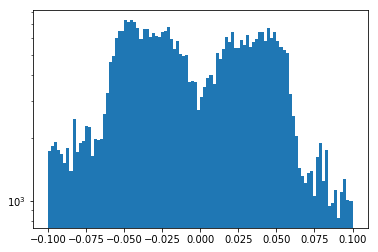

dphiNor


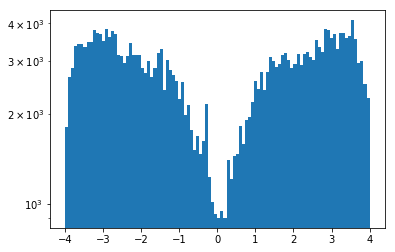

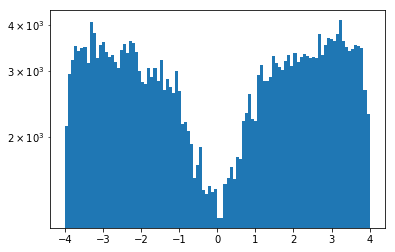

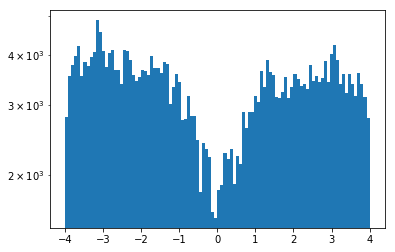

dz


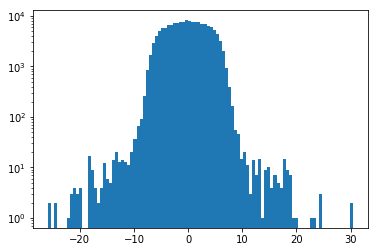

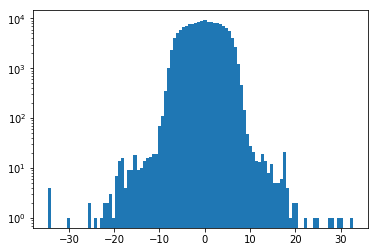

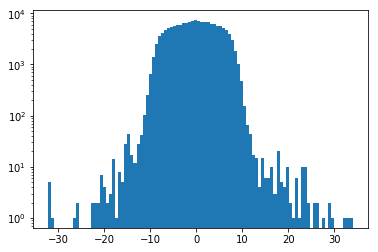

z0


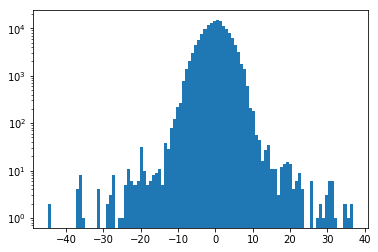

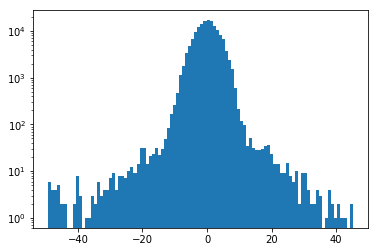

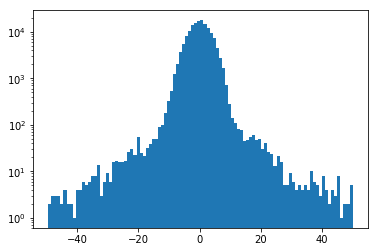

dr


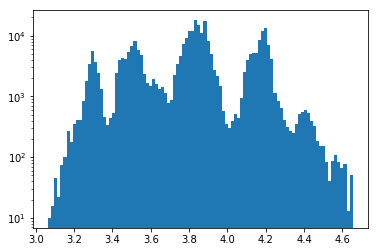

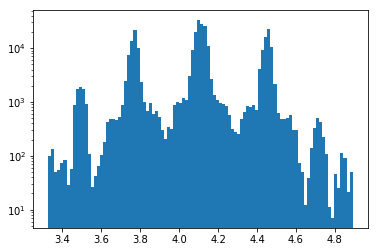

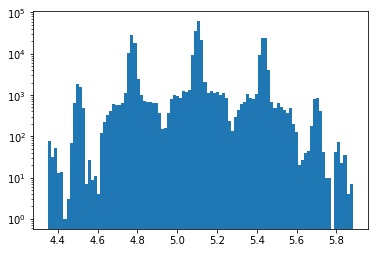

dphi zcut


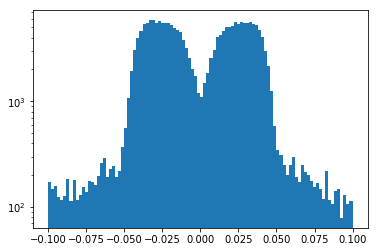

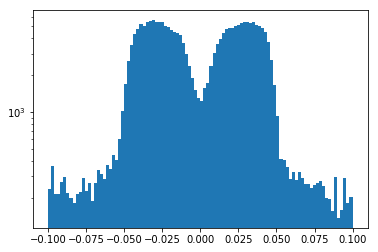

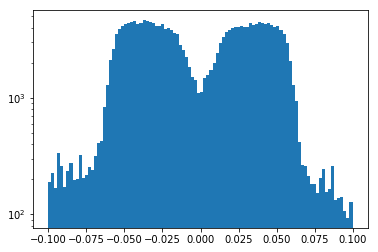

dphi


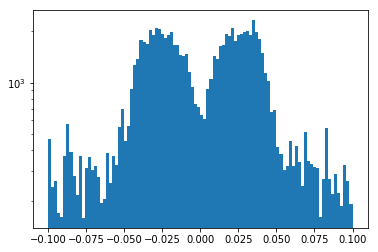

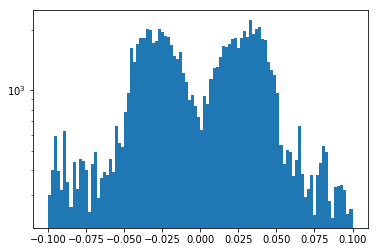

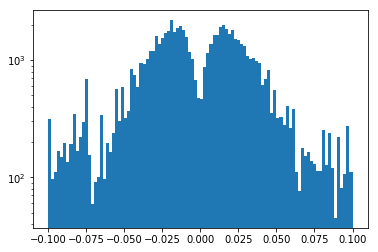

dphiNor


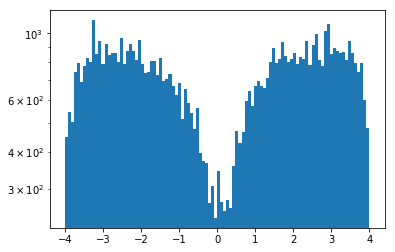

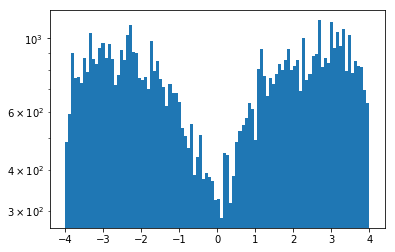

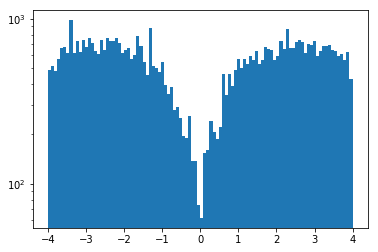

dz


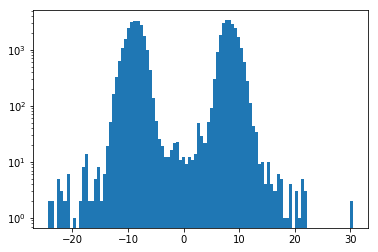

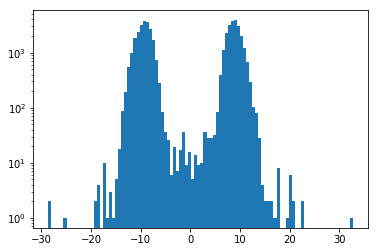

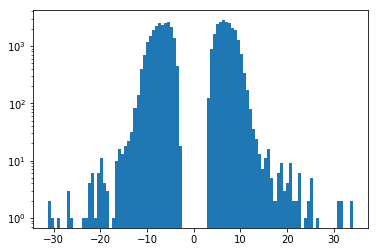

z0


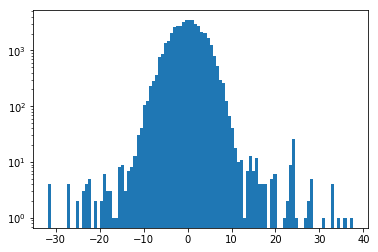

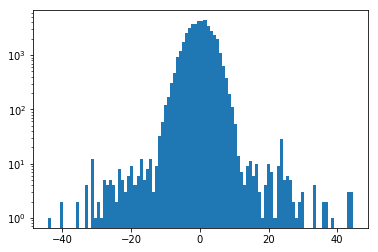

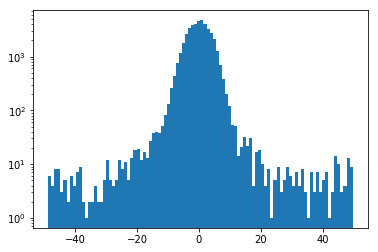

dr


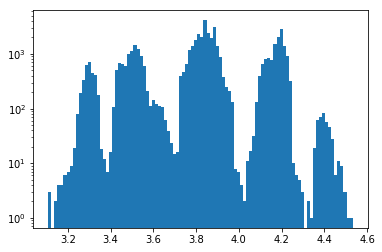

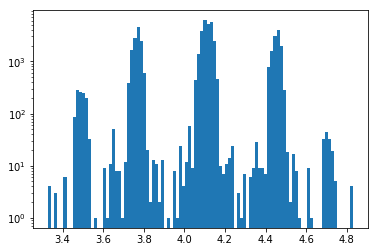

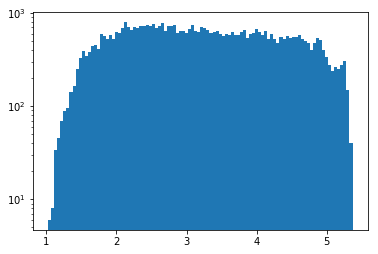

dphi zcut


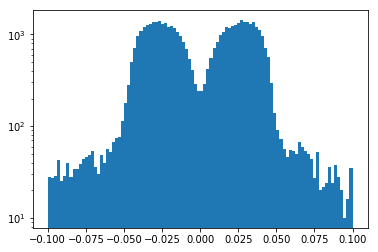

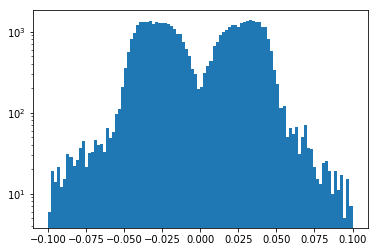

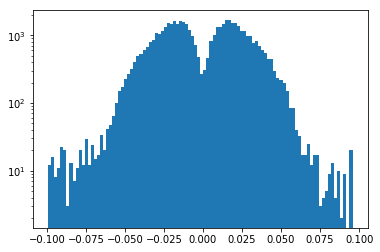

dphi


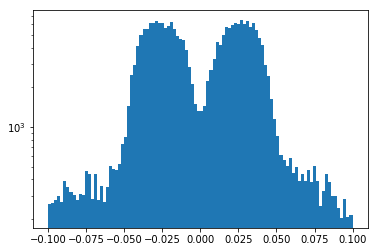

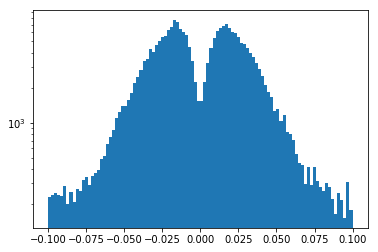

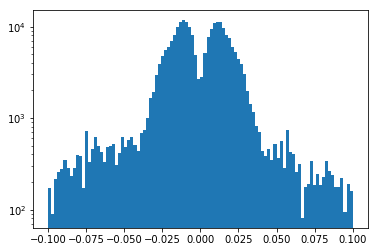

dphiNor


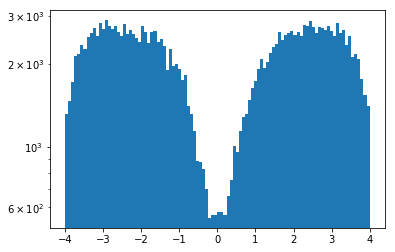

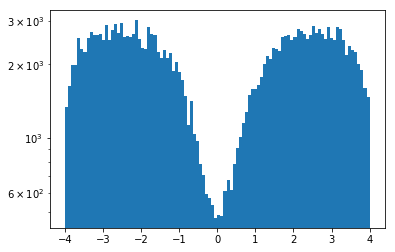

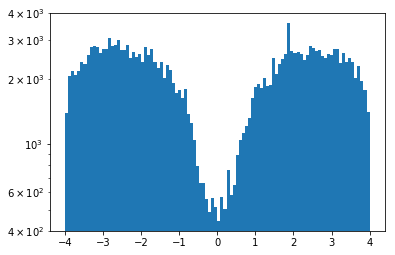

dz


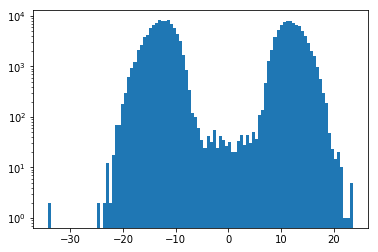

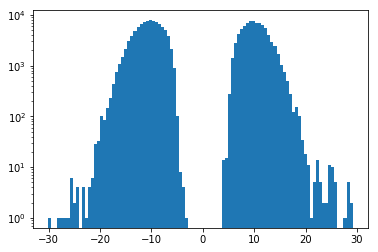

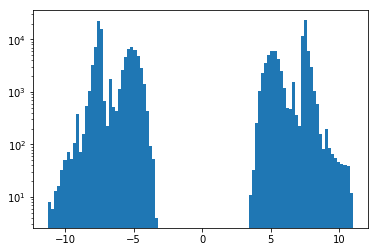

z0


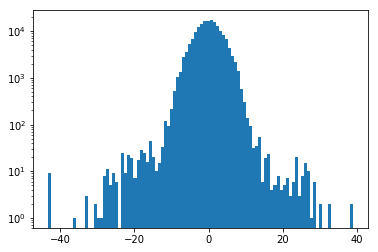

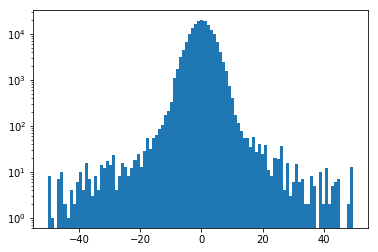

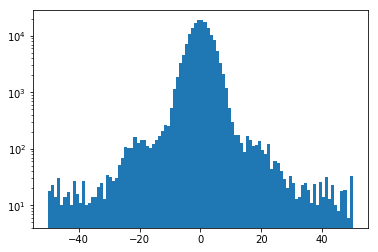

dr


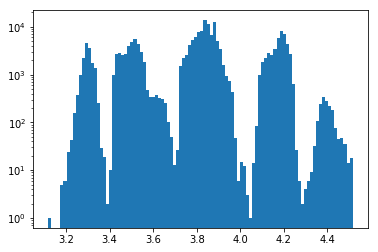

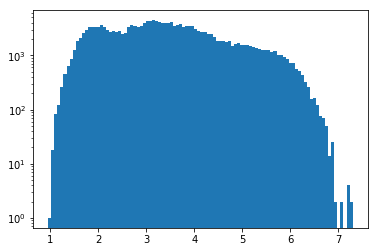

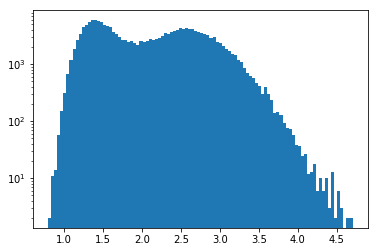

dphi zcut


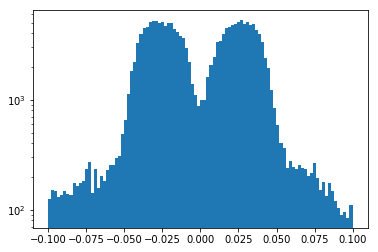

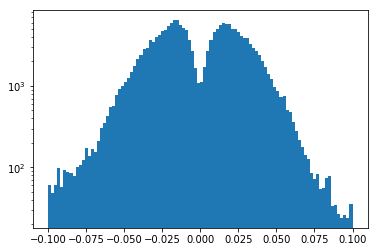

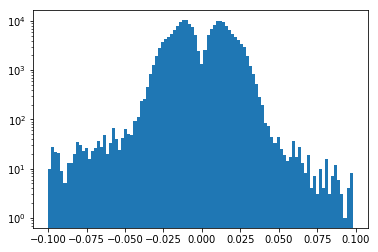

dphi


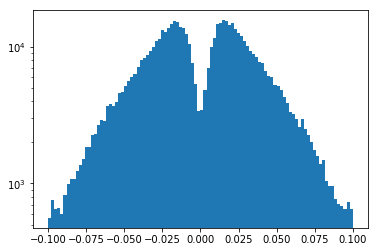

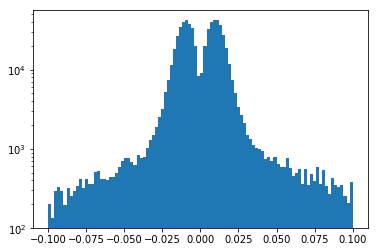

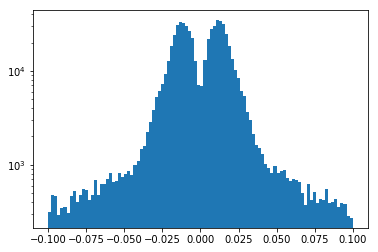

dphiNor


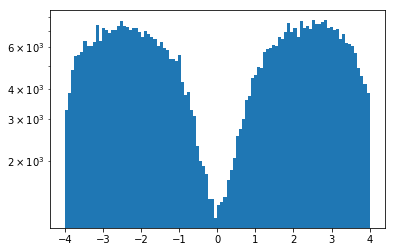

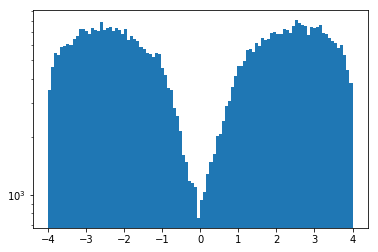

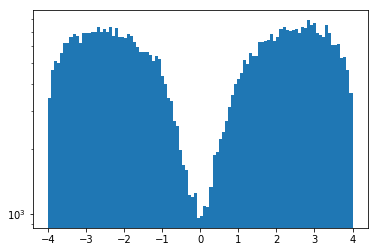

dz


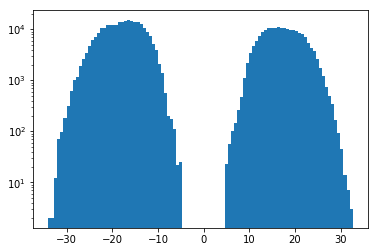

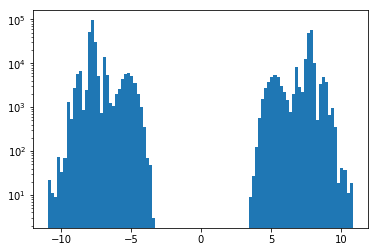

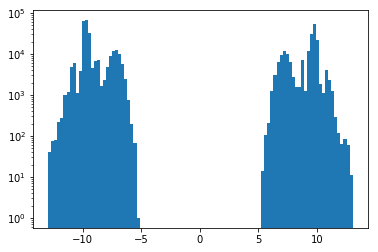

z0


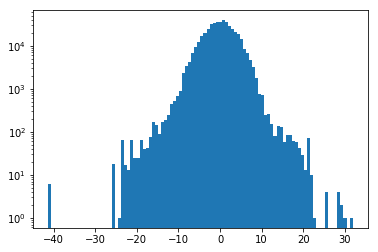

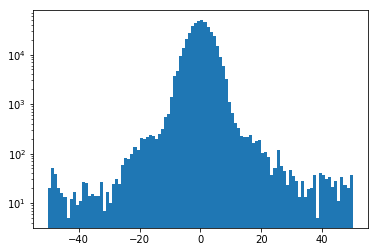

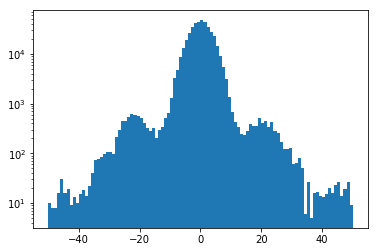

dr


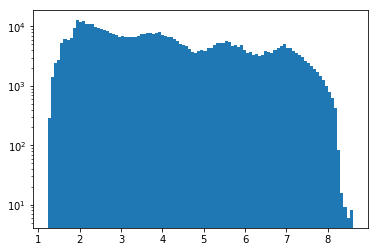

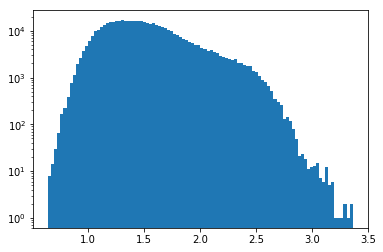

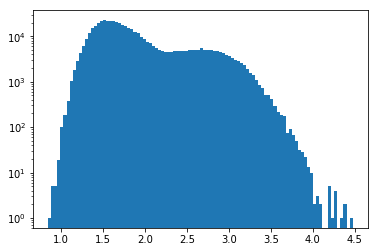

dphi zcut


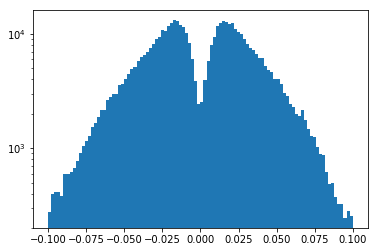

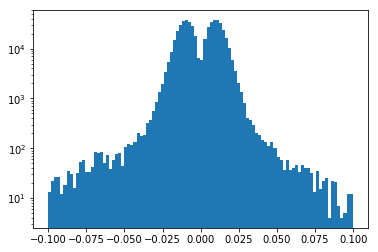

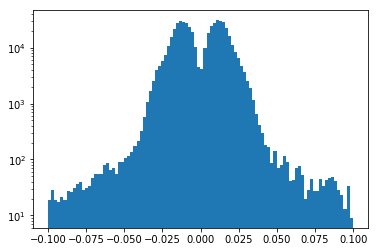

In [165]:
for quad in [t1234,t1231,t1212,t1123] :
  plotDoublets(quad,500)